<a href="https://colab.research.google.com/github/ShambhaviBhandari/Break-Through-Tech-Salesforce-1a/blob/Chris's-branch/Chris_Model_Salesforce_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salesforce Project


In [ ]:
import yfinance as yf, pandas as pd, numpy as np
import os, shutil, kagglehub
import torch
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


## Data Preparations

### Get the stocks prices


In [ ]:
# https://gist.github.com/yashveersinghsohi/060d1dc1311142f387d1c0ba8267e230
# for dowloading S&P 500
TICKERS = ["AAPL","MSFT","GOOGL","AMZN","META","NVDA","TSLA","SPY", "^GSPC"]
START, END = "2015-01-01", None

data = yf.download(" ".join(TICKERS), start=START, end=END, auto_adjust=True, actions=True)

stacked = (data.stack(level=1)
        .rename_axis(index=["Date","Ticker"])
        .reset_index()
        .sort_values(["Ticker","Date"]))

stacked['Ticker'] = stacked['Ticker'].replace('^GSPC', 'S&P 500')
SP500_df = stacked[stacked['Ticker'] == 'S&P 500']

[*********************100%***********************]  9 of 9 completed
/tmp/ipython-input-2564575360.py:8: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  stacked = (data.stack(level=1)


In [ ]:
SP500_df = SP500_df.drop(columns = ['Capital Gains', 'Dividends', 'Stock Splits'])

In [ ]:
SP500_df

Price,Date,Ticker,Close,High,Low,Open,Volume
8,2015-01-02,S&P 500,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
17,2015-01-05,S&P 500,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
26,2015-01-06,S&P 500,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
35,2015-01-07,S&P 500,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
44,2015-01-08,S&P 500,2062.139893,2064.080078,2030.609985,2030.609985,3934010000
...,...,...,...,...,...,...,...
24659,2025-11-21,S&P 500,6602.990234,6660.049805,6521.919922,6555.770020,5929930000
24668,2025-11-24,S&P 500,6705.120117,6715.750000,6630.700195,6636.540039,6039740000
24677,2025-11-25,S&P 500,6765.879883,6776.399902,6659.979980,6697.029785,5003330000
24686,2025-11-26,S&P 500,6812.609863,6831.439941,6783.870117,6793.549805,4485000000


In [ ]:
temp = SP500_df.copy()
cols = temp.select_dtypes(include=np.number).columns
windows = [3, 5, 10, 20]
new_features = temp
for window in windows:
  for col in cols:
    new_features[f'Rolling_{col}_mean_{window}'] = temp[col].rolling(window).mean()
new_features

Price,Date,Ticker,Close,High,Low,Open,Volume,Rolling_Close_mean_3,Rolling_High_mean_3,Rolling_Low_mean_3,...,Rolling_Close_mean_10,Rolling_High_mean_10,Rolling_Low_mean_10,Rolling_Open_mean_10,Rolling_Volume_mean_10,Rolling_Close_mean_20,Rolling_High_mean_20,Rolling_Low_mean_20,Rolling_Open_mean_20,Rolling_Volume_mean_20
8,2015-01-02,S&P 500,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2015-01-05,S&P 500,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,2015-01-06,S&P 500,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,2027.129964,2052.350016,2018.606649,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,2015-01-07,S&P 500,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,2016.363322,2038.099976,2005.109985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2015-01-08,S&P 500,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,2030.216634,2041.313354,2009.533325,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24659,2025-11-21,S&P 500,6602.990234,6660.049805,6521.919922,6555.770020,5929930000,6594.636719,6706.716634,6553.156576,...,6707.520020,6770.999951,6665.133008,6724.172021,5.307076e+09,6763.165503,6811.896924,6727.112476,6777.996021,5.625562e+09
24668,2025-11-24,S&P 500,6705.120117,6715.750000,6630.700195,6636.540039,6039740000,6615.623372,6715.383301,6562.223307,...,6694.789014,6758.442969,6651.147021,6709.290039,5.374445e+09,6754.663501,6803.820435,6716.450488,6767.550024,5.663017e+09
24677,2025-11-25,S&P 500,6765.879883,6776.399902,6659.979980,6697.029785,5003330000,6691.330078,6717.399902,6604.200033,...,6686.716016,6750.569971,6636.458008,6697.429004,5.376429e+09,6748.412988,6797.075439,6705.912988,6757.514502,5.628387e+09
24686,2025-11-26,S&P 500,6812.609863,6831.439941,6783.870117,6793.549805,4485000000,6761.203288,6774.529948,6691.516764,...,6682.885010,6746.722949,6631.883008,6690.006982,5.295568e+09,6744.513989,6792.630444,6702.510986,6751.644482,5.538630e+09


In [ ]:
# Import ln(Open_t / Close_t-1) as y_2 for another method
# also use Open_t as y
temp_df_1 = pd.DataFrame(SP500_df[['Close', 'Open']].shift(-1))
temp_df_1.columns = ['Close_t+1', 'Open_t+1']
temp_df_1 = temp_df_1.join(new_features)
temp_df_1 = temp_df_1.dropna()
temp_df_1['Close_t+1/Close_t'] = temp_df_1['Close_t+1'] / temp_df_1['Close']
temp_df_1['ln(Close_t+1/Close_t)'] = np.log(temp_df_1['Close_t+1/Close_t'])
temp_df_1['Open_t+1/Close_t'] = temp_df_1['Open_t+1'] / temp_df_1['Close']
temp_df_1['ln(Open_t+1/Close_t)'] = np.log(temp_df_1['Open_t+1/Close_t'])
temp_df_1.reset_index(drop=True, inplace=True)
ys = ['Open_t+1', 'ln(Open_t+1/Close_t)', 'Close_t+1', 'ln(Close_t+1/Close_t)']

final_df = temp_df_1.drop(columns = ['Open_t+1/Close_t', 'Close_t+1/Close_t'])
final_df

,Close_t+1,Open_t+1,Date,Ticker,Close,High,Low,Open,Volume,Rolling_Close_mean_3,...,Rolling_Low_mean_10,Rolling_Open_mean_10,Rolling_Volume_mean_10,Rolling_Close_mean_20,Rolling_High_mean_20,Rolling_Low_mean_20,Rolling_Open_mean_20,Rolling_Volume_mean_20,ln(Close_t+1/Close_t),ln(Open_t+1/Close_t)
0,2020.849976,1996.670044,2015-01-30,S&P 500,1994.989990,2023.319946,1993.380005,2019.349976,4568650000,2006.133341,...,2012.650012,2028.289978,3.903932e+09,2028.178510,2043.618506,2013.377496,2031.392981,3.866502e+09,0.012879,0.000842
1,2050.030029,2022.709961,2015-02-02,S&P 500,2020.849976,2021.660034,1980.900024,1996.670044,4008330000,2012.363322,...,2011.928015,2028.731982,3.899124e+09,2026.311011,2041.083502,2010.120496,2028.281488,3.931484e+09,0.014336,0.000920
2,2041.510010,2048.860107,2015-02-03,S&P 500,2050.030029,2050.300049,2022.709961,2022.709961,4615900000,2021.956665,...,2013.750012,2028.926978,3.966280e+09,2027.783514,2040.876508,2010.388995,2026.694989,3.972322e+09,-0.004165,-0.000571
3,2062.520020,2043.449951,2015-02-04,S&P 500,2041.510010,2054.739990,2036.719971,2048.860107,4141920000,2037.463338,...,2016.218005,2031.793994,4.007465e+09,2029.728516,2042.101007,2012.602997,2028.030493,3.956413e+09,0.010239,0.000950
4,2055.469971,2062.280029,2015-02-05,S&P 500,2062.520020,2063.550049,2043.449951,2043.449951,3821990000,2051.353353,...,2017.925000,2032.708984,3.972059e+09,2031.559515,2043.798010,2014.497992,2029.925488,3.957238e+09,-0.003424,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,6602.990234,6555.770020,2025-11-20,S&P 500,6538.759766,6770.350098,6534.049805,6737.930176,5596080000,6599.413249,...,6676.085010,6738.213037,5.306690e+09,6772.600488,6819.249927,6739.619971,6788.811011,5.581977e+09,0.009775,0.002598
2720,6705.120117,6636.540039,2025-11-21,S&P 500,6602.990234,6660.049805,6521.919922,6555.770020,5929930000,6594.636719,...,6665.133008,6724.172021,5.307076e+09,6763.165503,6811.896924,6727.112476,6777.996021,5.625562e+09,0.015349,0.005068
2721,6765.879883,6697.029785,2025-11-24,S&P 500,6705.120117,6715.750000,6630.700195,6636.540039,6039740000,6615.623372,...,6651.147021,6709.290039,5.374445e+09,6754.663501,6803.820435,6716.450488,6767.550024,5.663017e+09,0.009021,-0.001207
2722,6812.609863,6793.549805,2025-11-25,S&P 500,6765.879883,6776.399902,6659.979980,6697.029785,5003330000,6691.330078,...,6636.458008,6697.429004,5.376429e+09,6748.412988,6797.075439,6705.912988,6757.514502,5.628387e+09,0.006883,0.004081


In [ ]:
ys

['Open_t+1', 'ln(Open_t+1/Close_t)', 'Close_t+1', 'ln(Close_t+1/Close_t)']

### Get the news data from the kaggle

In [ ]:
# Kaggle Data loading and putting in the content folder
# !pip -q install kagglehub

src_path = kagglehub.dataset_download("notlucasp/financial-news-headlines")
print("KaggleHub cached at:", src_path)

dst_dir = "/content/news_data"
shutil.copytree(src_path, dst_dir, dirs_exist_ok=True)


Using Colab cache for faster access to the 'financial-news-headlines' dataset.
KaggleHub cached at: /kaggle/input/financial-news-headlines


'/content/news_data'

In [ ]:
cnbc = pd.read_csv('news_data/cnbc_headlines.csv')
guardian = pd.read_csv('news_data/guardian_headlines.csv')
reuters = pd.read_csv('news_data/reuters_headlines.csv')
cnbc = cnbc.dropna().reset_index(drop=True)
guardian = guardian.dropna().reset_index(drop=True)
reuters = reuters.dropna().reset_index(drop=True)

#### Convert the Time format in news to the prices

In [ ]:
def convert_date(date):
  return pd.to_datetime(date).strftime("%Y-%m-%d")

cnbc['Trading Date'] = cnbc['Time'].str.split(', ').str[1]
cnbc['Date'] = cnbc['Trading Date'].apply(convert_date)
cnbc_df = cnbc[['Headlines', 'Date']]
cnbc_df['Source'] = 'CNBC'

/tmp/ipython-input-3776164757.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cnbc_df['Source'] = 'CNBC'


In [ ]:
def convert_date_guardian(info):
  day = info[0]
  month = info[1]
  year = '20' + info[2]
  date = day + ' ' + month + ' ' + year
  return pd.to_datetime(date).strftime("%Y-%m-%d")
guardian['Trading Date'] = guardian['Time'].str.split('-')
guardian = guardian[guardian['Trading Date'].str.len() >= 3]
guardian['Date'] = guardian['Trading Date'].apply(convert_date_guardian)

guardian_df = guardian[['Headlines', 'Date']]
guardian_df['Source'] = 'Guardian'

/tmp/ipython-input-1885545419.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  guardian_df['Source'] = 'Guardian'


In [ ]:
reuters['Date'] = reuters['Time'].apply(convert_date)
reuters_df = reuters[['Headlines', 'Date']]
reuters_df['Source'] = 'Reuters'

/tmp/ipython-input-1208677301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reuters_df['Source'] = 'Reuters'


In [ ]:
all_news = pd.concat([cnbc_df, guardian_df, reuters_df], ignore_index=True)
all_news.sort_values(by='Date', inplace=True)

In [ ]:
all_news.reset_index(drop=True, inplace=True)
all_news

,Headlines,Date,Source
0,The Guardian view on Ryanair’s model: a union-...,2017-12-17,Guardian
1,Butchers carve out a niche as UK shoppers opt ...,2017-12-17,Guardian
2,Grogonomics \n\n\n This year has been about ...,2017-12-17,Guardian
3,Youngest staff to be given UK workplace pensio...,2017-12-17,Guardian
4,Peter Preston on press and broadcasting \n\n\...,2017-12-17,Guardian
...,...,...,...
53325,World Bank calls on creditors to cut poorest n...,2020-07-18,Guardian
53326,British Airways retires Boeing 747 fleet as Co...,2020-07-18,Guardian
53327,What will changes to England's lockdown rules ...,2020-07-18,Guardian
53328,Atol protection to be extended to vouchers on ...,2020-07-18,Guardian


### Work on the new's analysis

In [ ]:
df_finbert = all_news.copy()
print("GPU available:", torch.cuda.is_available())
device = 0 if torch.cuda.is_available() else -1
MODEL_NAME = "ProsusAI/finbert"
clf = pipeline(
    "text-classification",
    model=MODEL_NAME,
    tokenizer=MODEL_NAME,
    return_all_scores=True,
    truncation=True,
    batch_size=32,
    device=device
)

def batched(iterable, n=512):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

all_scores = []
headlines_list = df_finbert["Headlines"].tolist()
for batch in batched(headlines_list, n=512):
    all_scores.extend(clf(batch))

# labels = []
pos_prob, neu_prob, neg_prob = [], [], []
for score_list in all_scores:
    d = {s["label"].lower(): s["score"] for s in score_list}
    pos_prob.append(d.get("positive", d.get("pos", 0.0)))
    neu_prob.append(d.get("neutral", d.get("neu", 0.0)))
    neg_prob.append(d.get("negative", d.get("neg", 0.0)))
    # labels.append(max(d, key=d.get))

# df["label"] = labels
df_finbert["p_pos"] = pos_prob
df_finbert["p_neu"] = neu_prob
df_finbert["p_neg"] = neg_prob
df_finbert

GPU available: True


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,Headlines,Date,Source,p_pos,p_neu,p_neg
0,The Guardian view on Ryanair’s model: a union-...,2017-12-17,Guardian,0.079081,0.903235,0.017684
1,Butchers carve out a niche as UK shoppers opt ...,2017-12-17,Guardian,0.321952,0.658565,0.019483
2,Grogonomics \n\n\n This year has been about ...,2017-12-17,Guardian,0.036052,0.678951,0.284997
3,Youngest staff to be given UK workplace pensio...,2017-12-17,Guardian,0.024376,0.539174,0.436449
4,Peter Preston on press and broadcasting \n\n\...,2017-12-17,Guardian,0.040036,0.904399,0.055565
...,...,...,...,...,...,...
53325,World Bank calls on creditors to cut poorest n...,2020-07-18,Guardian,0.043782,0.098705,0.857514
53326,British Airways retires Boeing 747 fleet as Co...,2020-07-18,Guardian,0.037162,0.101310,0.861529
53327,What will changes to England's lockdown rules ...,2020-07-18,Guardian,0.042328,0.881697,0.075974
53328,Atol protection to be extended to vouchers on ...,2020-07-18,Guardian,0.290971,0.698193,0.010837


In [ ]:
def aggregate_sentiment_features(df_in):
    agg_dict = {
        'sent_pos_mean': df_in['p_pos'].mean(),
        'sent_neg_mean': df_in['p_neg'].mean(),
        'sent_neu_mean': df_in['p_neu'].mean(),
        'n_headlines': df_in.shape[0],
        'n_strong_pos': (df_in['p_pos'] > 0.8).sum(), # Positive
        'n_strong_neg': (df_in['p_neg'] > 0.8).sum()  # Negtive
    }
    return pd.Series(agg_dict)

df_finbert['Date'] = pd.to_datetime(df_finbert['Date'])
df_agg_rich = df_finbert.groupby(['Date', 'Source']).apply(aggregate_sentiment_features).reset_index()

df_pivot = df_agg_rich.pivot(index='Date', columns='Source',
                        values=['sent_pos_mean', 'sent_neg_mean', 'sent_neu_mean',
                                'n_headlines', 'n_strong_pos', 'n_strong_neg'])

/tmp/ipython-input-1766108921.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_agg_rich = df_finbert.groupby(['Date', 'Source']).apply(aggregate_sentiment_features).reset_index()


In [ ]:
news_features_agg = df_pivot.fillna(0)
news_features_agg.columns = ['_'.join(col).strip() for col in news_features_agg.columns.values]
news_features_agg = news_features_agg.reset_index()
news_features_agg

,Date,sent_pos_mean_CNBC,sent_pos_mean_Guardian,sent_pos_mean_Reuters,sent_neg_mean_CNBC,sent_neg_mean_Guardian,sent_neg_mean_Reuters,sent_neu_mean_CNBC,sent_neu_mean_Guardian,sent_neu_mean_Reuters,n_headlines_CNBC,n_headlines_Guardian,n_headlines_Reuters,n_strong_pos_CNBC,n_strong_pos_Guardian,n_strong_pos_Reuters,n_strong_neg_CNBC,n_strong_neg_Guardian,n_strong_neg_Reuters
0,2017-12-17,0.000000,0.174274,0.000000,0.000000,0.287308,0.000000,0.000000,0.538418,0.000000,0.0,20.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0
1,2017-12-18,0.000000,0.134951,0.000000,0.000000,0.427190,0.000000,0.000000,0.437860,0.000000,0.0,40.0,0.0,0.0,2.0,0.0,0.0,11.0,0.0
2,2017-12-19,0.000000,0.098566,0.000000,0.000000,0.410148,0.000000,0.000000,0.491286,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
3,2017-12-20,0.000000,0.153501,0.000000,0.000000,0.408590,0.000000,0.000000,0.437910,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
4,2017-12-21,0.000000,0.094427,0.000000,0.000000,0.396805,0.000000,0.000000,0.508767,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,2020-07-14,0.150458,0.271249,0.225203,0.378527,0.314561,0.401844,0.471015,0.414190,0.372953,3.0,20.0,91.0,0.0,3.0,7.0,1.0,2.0,25.0
927,2020-07-15,0.481253,0.180010,0.318250,0.027648,0.412896,0.314640,0.491099,0.407094,0.367110,4.0,40.0,79.0,1.0,1.0,11.0,0.0,13.0,16.0
928,2020-07-16,0.278080,0.109151,0.213740,0.243662,0.570469,0.406769,0.478258,0.320381,0.379491,4.0,20.0,93.0,1.0,1.0,11.0,1.0,10.0,26.0
929,2020-07-17,0.388681,0.170873,0.188403,0.022741,0.392595,0.435086,0.588578,0.436532,0.376511,4.0,20.0,48.0,1.0,1.0,3.0,0.0,6.0,13.0


In [ ]:
final_df['Date'] = pd.to_datetime(final_df['Date'])
news_features_agg['Date'] = pd.to_datetime(news_features_agg['Date'])
feat_df = pd.merge(final_df, news_features_agg, on='Date', how='left')

In [ ]:
news_cols = [col for col in news_features_agg.columns if col != 'Date']
feat_df[news_cols] = feat_df[news_cols].fillna(0)
feat_df = feat_df.dropna()
feat_df = feat_df[(feat_df['Date']>= news_features_agg['Date'].min()) \
                  & (feat_df['Date'] <= news_features_agg['Date'].max())]

## All data before modeling

In [ ]:
ys

['Open_t+1', 'ln(Open_t+1/Close_t)', 'Close_t+1', 'ln(Close_t+1/Close_t)']

In [ ]:
feat_df

,Close_t+1,Open_t+1,Date,Ticker,Close,High,Low,Open,Volume,Rolling_Close_mean_3,...,sent_neu_mean_Reuters,n_headlines_CNBC,n_headlines_Guardian,n_headlines_Reuters,n_strong_pos_CNBC,n_strong_pos_Guardian,n_strong_pos_Reuters,n_strong_neg_CNBC,n_strong_neg_Guardian,n_strong_neg_Reuters
727,2681.469971,2692.709961,2017-12-18,S&P 500,2690.159912,2694.969971,2685.919922,2685.919922,3727770000,2672.659993,...,0.000000,0.0,40.0,0.0,0.0,2.0,0.0,0.0,11.0,0.0
728,2679.250000,2688.179932,2017-12-19,S&P 500,2681.469971,2694.439941,2680.739990,2692.709961,3407680000,2682.479980,...,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0
729,2684.570068,2683.020020,2017-12-20,S&P 500,2679.250000,2691.010010,2676.110107,2688.179932,3246230000,2683.626628,...,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
730,2683.340088,2684.219971,2017-12-21,S&P 500,2684.570068,2692.639893,2682.399902,2683.020020,3293130000,2681.763346,...,0.000000,0.0,20.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
731,2680.500000,2679.090088,2017-12-22,S&P 500,2683.340088,2685.350098,2678.129883,2684.219971,2401030000,2682.386719,...,0.000000,3.0,20.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1371,3197.520020,3141.110107,2020-07-13,S&P 500,3155.219971,3235.320068,3149.429932,3205.080078,4902440000,3164.103353,...,0.423877,5.0,20.0,60.0,0.0,1.0,7.0,2.0,9.0,15.0
1372,3226.560059,3225.979980,2020-07-14,S&P 500,3197.520020,3200.949951,3127.659912,3141.110107,4507140000,3179.260010,...,0.372953,3.0,20.0,91.0,0.0,3.0,7.0,1.0,2.0,25.0
1373,3215.570068,3208.360107,2020-07-15,S&P 500,3226.560059,3238.280029,3200.760010,3225.979980,4686830000,3193.100016,...,0.367110,4.0,40.0,79.0,1.0,1.0,11.0,0.0,13.0,16.0
1374,3224.729980,3224.209961,2020-07-16,S&P 500,3215.570068,3220.389893,3198.590088,3208.360107,3972860000,3213.216715,...,0.379491,4.0,20.0,93.0,1.0,1.0,11.0,1.0,10.0,26.0


In [ ]:
final_df

,Close_t+1,Open_t+1,Date,Ticker,Close,High,Low,Open,Volume,Rolling_Close_mean_3,...,Rolling_Low_mean_10,Rolling_Open_mean_10,Rolling_Volume_mean_10,Rolling_Close_mean_20,Rolling_High_mean_20,Rolling_Low_mean_20,Rolling_Open_mean_20,Rolling_Volume_mean_20,ln(Close_t+1/Close_t),ln(Open_t+1/Close_t)
0,2020.849976,1996.670044,2015-01-30,S&P 500,1994.989990,2023.319946,1993.380005,2019.349976,4568650000,2006.133341,...,2012.650012,2028.289978,3.903932e+09,2028.178510,2043.618506,2013.377496,2031.392981,3.866502e+09,0.012879,0.000842
1,2050.030029,2022.709961,2015-02-02,S&P 500,2020.849976,2021.660034,1980.900024,1996.670044,4008330000,2012.363322,...,2011.928015,2028.731982,3.899124e+09,2026.311011,2041.083502,2010.120496,2028.281488,3.931484e+09,0.014336,0.000920
2,2041.510010,2048.860107,2015-02-03,S&P 500,2050.030029,2050.300049,2022.709961,2022.709961,4615900000,2021.956665,...,2013.750012,2028.926978,3.966280e+09,2027.783514,2040.876508,2010.388995,2026.694989,3.972322e+09,-0.004165,-0.000571
3,2062.520020,2043.449951,2015-02-04,S&P 500,2041.510010,2054.739990,2036.719971,2048.860107,4141920000,2037.463338,...,2016.218005,2031.793994,4.007465e+09,2029.728516,2042.101007,2012.602997,2028.030493,3.956413e+09,0.010239,0.000950
4,2055.469971,2062.280029,2015-02-05,S&P 500,2062.520020,2063.550049,2043.449951,2043.449951,3821990000,2051.353353,...,2017.925000,2032.708984,3.972059e+09,2031.559515,2043.798010,2014.497992,2029.925488,3.957238e+09,-0.003424,-0.000116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,6602.990234,6555.770020,2025-11-20,S&P 500,6538.759766,6770.350098,6534.049805,6737.930176,5596080000,6599.413249,...,6676.085010,6738.213037,5.306690e+09,6772.600488,6819.249927,6739.619971,6788.811011,5.581977e+09,0.009775,0.002598
2720,6705.120117,6636.540039,2025-11-21,S&P 500,6602.990234,6660.049805,6521.919922,6555.770020,5929930000,6594.636719,...,6665.133008,6724.172021,5.307076e+09,6763.165503,6811.896924,6727.112476,6777.996021,5.625562e+09,0.015349,0.005068
2721,6765.879883,6697.029785,2025-11-24,S&P 500,6705.120117,6715.750000,6630.700195,6636.540039,6039740000,6615.623372,...,6651.147021,6709.290039,5.374445e+09,6754.663501,6803.820435,6716.450488,6767.550024,5.663017e+09,0.009021,-0.001207
2722,6812.609863,6793.549805,2025-11-25,S&P 500,6765.879883,6776.399902,6659.979980,6697.029785,5003330000,6691.330078,...,6636.458008,6697.429004,5.376429e+09,6748.412988,6797.075439,6705.912988,6757.514502,5.628387e+09,0.006883,0.004081


## Model

### Modeling Data




In [ ]:
feature_cols = [c for c in feat_df.columns if c not in ys+['Date', 'Ticker']]

X = feat_df.drop(columns=ys + ['Date', 'Ticker'])
y = feat_df[ys[0]]
split_idx = int(len(y) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

### Lasso

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
model_Lasso = LassoCV(cv=5, random_state=42, n_jobs=-1, verbose=1)
model_Lasso.fit(X_train_scaled, y_train)
y_pred_Lasso = model_Lasso.predict(X_test_scaled)

y_pred_naive = X_test['Close']

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [ ]:
r2_Lasso = r2_score(y_test, y_pred_Lasso)

print("\n--- Model Lasso Predict next open price ---")
print(f"Lasso best Alpha: {model_Lasso.alpha_:.4f}")
print(f"R²: {r2_Lasso:.4f}")
print("--------------------------------------------------")

# --- Compare MAE ---
mae_Lasso = mean_absolute_error(y_test, y_pred_Lasso)
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print(f"Naive MAE: {mae_naive:.2f}")
print(f"Lasso MAE: {mae_Lasso:.2f}")


--- Model Lasso Predict next open price ---
Lasso best Alpha: 0.5211
R²: 0.9778
--------------------------------------------------
Naive MAE: 27.84
Lasso MAE: 27.82


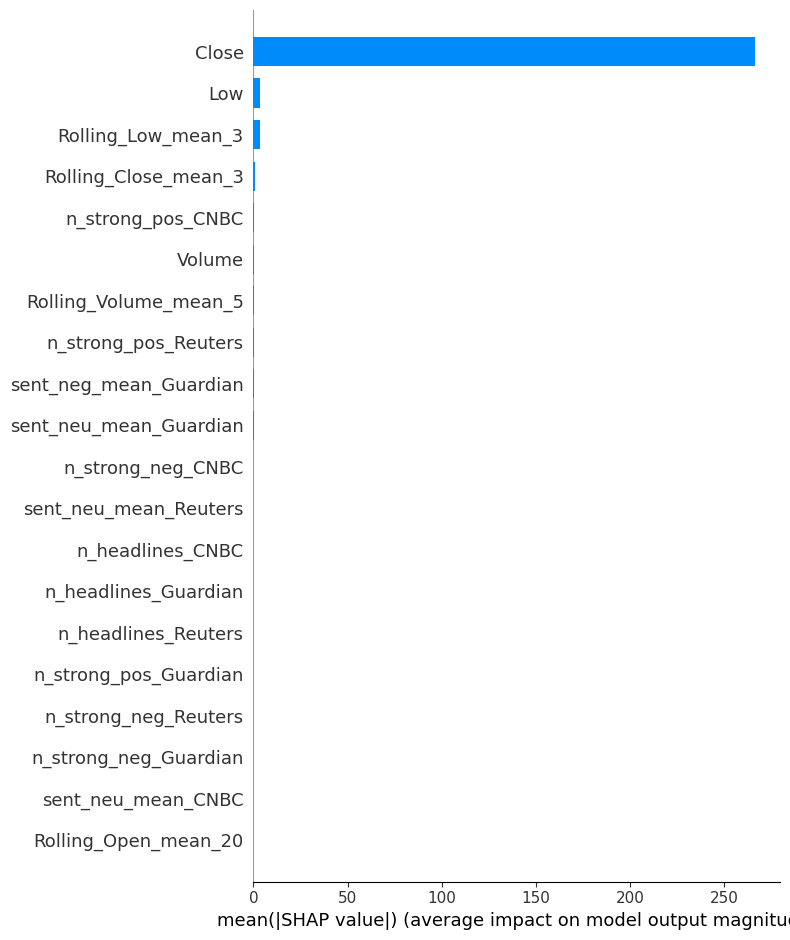

In [ ]:
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols)

explainer_lasso = shap.LinearExplainer(model_Lasso, X_train_df)
shap_values = explainer_lasso.shap_values(X_test_df)
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

### Random Forest

In [ ]:
model_RF = RandomForestRegressor(random_state=42)
param_grid_RF = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_RF = GridSearchCV(
    estimator=model_RF,
    param_grid=param_grid_RF,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

grid_search_RF.fit(X_train, y_train)

print("\nRandom Forest Training done。")
print(f"Random Forest Best: {grid_search_RF.best_params_}")

In [ ]:
best_model_RF = grid_search_RF.best_estimator_
y_pred_RF = best_model_RF.predict(X_test)
r2_RF = r2_score(y_test, y_pred_RF)
print("\n--- Model Random Forest Predict next open price ---")
print(f"R²: {r2_RF:.4f}")
print("--------------------------------------------------")

# --- Compare MAE ---
mae_RF = mean_absolute_error(y_test, y_pred_RF)

print(f"Naive MAE: {mae_naive:.2f}")
print(f"RF MAE: {mae_RF:.2f}")

In [ ]:
explainer_RF = shap.TreeExplainer(best_model_RF)

# Compute Shap value
shap_values_RF = explainer_RF(X_test)

# Bar Graph
print("\n--- Random Forest SHAP ---")
shap.summary_plot(shap_values_RF, X_test, plot_type="bar")

print("\n--- Random Forest SHAP Feature Impact ---")
shap.summary_plot(shap_values_RF,X_test)

### XGBoost

In [ ]:
print("--- Train XGBoost... ---")

# 1. define
model_XGB = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# 2. parameter
param_grid_XGB = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# do GridSearchCV
grid_search_XGB = GridSearchCV(
    estimator=model_XGB,
    param_grid=param_grid_XGB,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_absolute_error'
)
grid_search_XGB.fit(X_train, y_train)

print("\nXGBoost Training done。")
print(f"XGBoost Best: {grid_search_XGB.best_params_}")

In [ ]:
best_model_XGB = grid_search_XGB.best_estimator_
y_pred_XGB = best_model_XGB.predict(X_test)
r2_XGB = r2_score(y_test, y_pred_XGB)
print("\n--- Model XGBoost Predict next open price ---")
print(f"R²: {r2_XGB:.4f}")
print("--------------------------------------------------")

# --- Compare MAE ---
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
mae_naive = mean_absolute_error(y_test, y_pred_naive)

print(f"Naive MAE: {mae_naive:.2f}")
print(f"Lasso MAE: {mae_XGB:.2f}")

In [ ]:
explainer_XGB = shap.TreeExplainer(best_model_XGB)

# Compute Shap value
shap_values_XGB = explainer_XGB(X_test)

# Bar Graph
print("\n--- XGBoost SHAP ---")
shap.summary_plot(shap_values_XGB, X_test, plot_type="bar")

print("\n--- XGBoost SHAP Feature Impact ---")
shap.summary_plot(shap_values_XGB,X_test)

## Final Visualization


In [ ]:
# Compute all the errors
results = {
    'Model': ['Naive Benchmark', 'LassoCV', 'Random Forest', 'XGBoost'],
    'R²': [
        r2_score(y_test, y_pred_naive),
        r2_Lasso,
        r2_RF,
        r2_XGB
    ],
    'MAE': [
        mae_naive,
        mae_Lasso,
        mae_RF,
        mae_XGB
    ],
    'RMSE': [
        np.sqrt(mae_naive),
        np.sqrt(mae_Lasso),
        np.sqrt(mae_RF),
        np.sqrt(mae_XGB)
    ]
}

results_df = pd.DataFrame(results).set_index('Model')

print("Compare")
print(results_df.round(4))

#### Save the data and models

In [ ]:
feat_df = feat_df.set_index(keys= 'Date', drop = True).drop(columns = 'Ticker')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/MyDrive/BTT_Proj/data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
model_dir = '/content/drive/MyDrive/BTT_Proj/models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
feat_path = os.path.join(data_dir, 'feat_df.csv')
feat_df.to_csv(feat_path)
result_path = os.path.join(data_dir, 'result_df.csv')
results_df.to_csv(result_path)

In [ ]:
import pickle
Scaler_path = os.path.join(model_dir, 'scaler.pkl')
with open(Scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
Lasso_path = os.path.join(model_dir, 'model_Lasso.pkl')
with open(Lasso_path, 'wb') as f:
    pickle.dump(model_Lasso, f)


RF_path = os.path.join(model_dir, 'model_RF.pkl')
with open(RF_path, 'wb') as f:
    pickle.dump(best_model_RF, f)
XGB_path = os.path.join(model_dir, 'model_XGB.pkl')
with open(XGB_path, 'wb') as f:
    pickle.dump(best_model_XGB, f)